# Example Code for "Speech-to-text model for keyword spotting applications in the Papiamento language within a healthcare environment"

_This Jupyter Notebook provides a PyTorch implementation of the work carried out in the SISSTEM Bachelor thesis **"Speech-to-text model for keyword spotting applications in the Papiamento language within a healthcare environment"** at the University of Aruba._

It provides a demonstration of STT keyword spotting for the Papiamento language and contains a reproducible workflow for dataset loading, preprocessing, model training, and evaluation.

## License and Citation
This notebook is licensed under the [Apache 2.0 License](https://opensource.org/licenses/Apache-2.0). If you use this code, please cite it as follows:

```bibtex
@misc{papiamento_keyword_spotting,
  author = {Rajnherc, J.R.},
  title = {Speech-to-text model for keyword spotting applications in the Papiamento language within a healthcare environment},
  year = {2025},
  url = {pending}
}
```

# Imports


In [ ]:
from torchinfo import summary
from torchvision.datasets import DatasetFolder
from torchvision import transforms
from torch.utils.data import Subset, DataLoader
import torch.nn.functional as F
import torch.nn as nn
import torch
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import random
import sys
import os

# First we check that the necessary version of the librarires, from the requirements.txt file, are installed.
# If not, we re-install them using pip.


def check_package_versions(requirements_file: str) -> None:
    """
    Check if the required packages are installed and match the versions specified in requirements.txt.
    If not, install them using pip.

    Args:
        requirements_file (str): Path to the requirements.txt file containing package specifications.
    """
    # Load the contents of requirements.txt
    # Ensure that the project root directory (parent of the notebook) is the current working directory
    project_root = os.path.dirname(os.getcwd())
    requirements_file = os.path.join(project_root, requirements_file)
    if not os.path.exists(requirements_file):
        raise FileNotFoundError(
            f"Requirements file '{requirements_file}' not found.")

    required_package_versions = []
    with open(requirements_file, 'r') as file:
        required_packages = file.read().splitlines()
        # Skip empty lines and comments
        required_packages = [pkg.strip(
        ) for pkg in required_packages if pkg.strip() and not pkg.startswith('#')]
        required_package_versions = [
            pkg.split('==') for pkg in required_packages if '==' in pkg]

    # Use importlib.metadata to check installed package versions
    import importlib.metadata

    def get_installed_version(package):
        try:
            return importlib.metadata.version(package)
        except importlib.metadata.PackageNotFoundError:
            return None

    for package, version in required_package_versions:
        try:
            installed_version = get_installed_version(package)
            if installed_version != version:
                print(
                    f"Package '{package}' version mismatch: required {version}, found {installed_version}. Reinstalling...")
                os.system(
                    f"{sys.executable} -m pip install {package}=={version}")
            else:
                print(
                    f"Package '{package}' is already installed with the required version {version}.")
        except importlib.metadata.PackageNotFoundError:
            print(
                f"Package '{package}' not found. Installing version {version}...")
            os.system(f"{sys.executable} -m pip install {package}=={version}")


check_package_versions('requirements.txt')


def verify_num_workers_per_platform(num_workers: int = 2) -> int:
    """
    Verify the number of workers based on the platform.
    Used by DataLoader to set the no. workers when loading data.

    Args:
        num_workers (int): The number of workers to set.

    Returns:
        int: The verified number of workers.
    """
    import platform
    # Detect platform and set multiprocessing start method if needed
    if platform.system() == "Darwin":  # macOS
        import multiprocessing
        try:
            multiprocessing.set_start_method("fork")
            print("Multiprocessing start method set to 'fork' on macOS.")
            print(f"Variable NUM_WORKERS set to 2.")
            return 2
        except RuntimeError as e:
            print(
                f"Multiprocessing start method already set or not supported: {e}")
            print(f"Variable NUM_WORKERS set to 0.")
            return 0
    elif platform.system() == "Linux":
        print(f"Variable NUM_WORKERS set to 2.")
        return 2
    else:  # Windows or unknown
        print(f"Variable NUM_WORKERS set to 0.")
        return 0


NUM_WORKERS = verify_num_workers_per_platform(num_workers=2)

Package 'notebook' is already installed with the required version 7.4.3.
Package 'jupyter' is already installed with the required version 1.1.1.
Package 'torch' is already installed with the required version 2.7.1.
Package 'numpy' is already installed with the required version 2.3.1.
Package 'matplotlib' is already installed with the required version 3.10.3.
Package 'torchvision' is already installed with the required version 0.22.1.
Package 'torchinfo' is already installed with the required version 1.8.0.
Multiprocessing start method set to 'fork' on macOS.
Variable NUM_WORKERS set to 2.


# Dataset Download and Extraction

In [ ]:
# Download the zip file from the provided URL and extract it to the specified directory
def download_and_extract_dataset(url: str, compressed_file_name: str, extract_to: str, root_data_folder: str, overwrite=False, extract_only=True) -> str:
    """Downloads a zip file from the given URL and extracts it to the specified directory.

    Args:
        url (str): The URL of the zip file to download.
        compressed_file_name (str): The name of the zip file to be saved locally.
        extract_to (str): The directory where the contents should be extracted.
        root_data_folder (str): The root folder inside the zip file to extract.
        overwrite (bool): If True, will overwrite the existing files in the directory.
        extract_only (bool): If True, will only extract the contents if the directory is empty
        or does not exist.

    Returns:
        str: The path to the extracted dataset root directory.
    """
    import requests
    from zipfile import ZipFile
    from io import BytesIO

    # Check that there are a total of 16766 files in 7 folders (classes)
    def verify_dataset_files(directory: str) -> bool:
        exp_file_count = 16766
        exp_folder_count = 7
        total_files = 0
        total_dirs = 0
        for _, dirs, files in os.walk(directory):
            total_files += len(files)
            total_dirs += len(dirs)
        intact = total_files == exp_file_count and total_dirs == exp_folder_count
        print(
            f"Expected {exp_file_count} files and {exp_folder_count} folders.")
        print(f"Found {total_files} files and {total_dirs} folders.")
        return intact

    zip_file_name = compressed_file_name
    zip_file_path = os.path.join(os.getcwd(), zip_file_name)
    # Ensure the extract_to directory exists
    if not os.path.exists(extract_to):
        os.makedirs(extract_to)

    # If extract_only is False, we will always download the dataset
    if not extract_only:
        # Show download progress and save to zip_file_name
        with requests.get(url, stream=True) as response:
            if response.status_code == 200:
                total_length = int(response.headers.get('content-length', 0))
                chunk_size = 8192
                downloaded = 0
                with open(zip_file_name, 'wb') as f:
                    print("Downloading dataset...")
                    for chunk in response.iter_content(chunk_size=chunk_size):
                        if chunk:
                            f.write(chunk)
                            downloaded += len(chunk)
                            done = int(50 * downloaded /
                                       total_length) if total_length else 0
                            sys.stdout.write('\r[{}{}] {:.2f}%'.format(
                                '=' * done, ' ' * (50 - done),
                                100 * downloaded / total_length if total_length else 0))
                            sys.stdout.flush()
                    print()  # Newline after progress bar
                print(f"Download complete. Saved to {zip_file_name}.")
                with ZipFile(zip_file_path, 'r') as zip_file:
                    print(f"Extracting zip file to {extract_to}...")
                    zip_file.extractall(path=extract_to)
                print("Extraction complete.")
            else:
                print(
                    f"Failed to download dataset. Status code: {response.status_code}")

    # If overwrite is True, we extract the existing zip file
    if overwrite:
        # Check if the zip file already exists
        if os.path.exists(zip_file_path):
            try:
                print(f"Using existing zip file: {zip_file_path}")
                with ZipFile(zip_file_path, 'r') as zip_file:
                    print(f"Extracting zip file to {extract_to}...")
                    zip_file.extractall(path=extract_to)
                print("Extraction complete.")
            except Exception as e:
                print(f"Failed to extract zip file: {e}")
                print("The zip file may be corrupted. Please delete it and re-download.")
                return ''
        else:
            print(
                f"The zip file does not exist at {zip_file_path}. Set extract_only=False to download it.")
            return ''

    # Check if the dataset is already extracted and intact
    print(f"Checking if existing dataset is intact...")
    if verify_dataset_files(os.path.join(extract_to, root_data_folder)):
        print(f"Dataset is intact.")
    else:
        print(f"Dataset is incomplete or corrupted. Download again.")

    # Return the full dataset path
    dataset_path = os.path.join(
        os.getcwd(), "data_directory", "stft_spectrograms")
    print(f"Variable DATASET_PATH set to {dataset_path}.")
    return dataset_path


DATASET_PATH = download_and_extract_dataset(
    url="https://some_link_to_dataset.zip",
    compressed_file_name="stft_spectrograms.zip",
    extract_to="data_directory",
    root_data_folder="stft_spectrograms",
    overwrite=False,
    extract_only=True,
)

Checking if existing dataset is intact...
Expected 16766 files and 7 folders.
Found 16766 files and 7 folders.
Dataset is intact.
Variable DATASET_PATH set to /Volumes/Backup/UA/BachelorTheses/papiamento-keyword-spotting/notebook/data_directory/stft_spectrograms.


# Dataset Preprocessing and Loading

In [103]:
# Set the random seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


# Custom data loader for npz files
def npz_loader(path: str) -> np.ndarray:
    with np.load(path) as data:
        return data["arr_0"]


# Specify the seed worker
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)


def to_tensor_float(x):
    return torch.from_numpy(x).float()


def add_channel_dim(x):
    return x.unsqueeze(0)


# Custom dataset class to apply normalization transform
# Necessary because DatasetFolder doesn't support transforms on subsets
class ApplyNormalizeTransform(torch.utils.data.Dataset):
    def __init__(self, dataset, transform):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, idx):
        data, label = self.dataset[idx]
        return self.transform(data), label

    def __len__(self):
        return len(self.dataset)


def dataset_loader(dataset_path: str, num_workers: int) -> tuple:
    """
    Function to load the dataset using DatasetFolder from torchvision.
    It applies necessary transformations and splits the dataset into training and validation sets.

    Args:
        dataset_path (str): The path to the dataset.
        num_workers (int): The number of workers for DataLoader.
    """
    # Use imported functions from src/data_utils.py
    dataset = DatasetFolder(
        root=DATASET_PATH,
        loader=npz_loader,
        extensions=(".npz",),
        transform=transforms.Compose(
            [
                transforms.Lambda(to_tensor_float),
                transforms.Lambda(add_channel_dim),  # To add a channel dim
                transforms.Resize((32, 32)),
            ]
        ),
    )

    dataset_size = len(dataset)
    val_size = int(0.2 * dataset_size)
    train_size = dataset_size - val_size
    generator = torch.Generator().manual_seed(SEED)
    train_dataset, val_dataset = torch.utils.data.random_split(
        dataset, [train_size, val_size], generator=generator
    )

    # Get the mean and standard deviation from `train_dataset`, for normalization.
    # We use a temporary DataLoader to iterate through the dataset to calculate mean and std.
    temp_loader = DataLoader(
        train_dataset,
        batch_size=64,
        shuffle=False,
        num_workers=NUM_WORKERS,
        worker_init_fn=seed_worker,
        generator=generator,
    )

    # Calculate mean and std
    mean_sum = 0.0
    std_sum = 0.0
    num_batches = 0
    for data, _ in temp_loader:
        mean_sum += data.mean()
        std_sum += data.std()
        num_batches += 1

    mean = mean_sum / num_batches
    std = std_sum / num_batches

    # Now, apply the normalization transform to the datasets
    normalize_transform = transforms.Normalize(mean=[mean], std=[std])

    train_dataset = ApplyNormalizeTransform(train_dataset, normalize_transform)
    val_dataset = ApplyNormalizeTransform(val_dataset, normalize_transform)

    # This is used to split validation into val and test subsets
    num_shards = 2

    # Get all indices in the validation set
    all_indices = list(range(len(val_dataset)))

    # Test set: shard index 0
    test_indices = all_indices[0::num_shards]
    test_dataset = Subset(val_dataset, test_indices)
    # New validation set: shard index 1
    val_indices = all_indices[1::num_shards]
    val_dataset = Subset(val_dataset, val_indices)

    train_loader = DataLoader(
        train_dataset,
        batch_size=64,
        shuffle=True,
        num_workers=2,
        worker_init_fn=seed_worker,
        generator=generator,
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=64,
        shuffle=False,
        num_workers=2,
        worker_init_fn=seed_worker,
        generator=generator,
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=64,
        shuffle=False,
        num_workers=2,
        worker_init_fn=seed_worker,
        generator=generator,
    )

    class_names = dataset.classes
    print("Class names:", class_names)

    return mean, std, train_loader, val_loader, test_loader, class_names


# Load the subsets, the class names, the mean and std of the training set for normalization
mean, std, train_loader, val_loader, test_loader, class_names = dataset_loader(
    dataset_path=DATASET_PATH,
    num_workers=NUM_WORKERS,
)

Class names: ['Dolor', 'Masha_Danki', 'No', 'Resultado', 'SSIMSAN', 'Si', 'Unknown']


# Dataset Inspection and Visualization

Class: Dolor, File: 2919354496667662221.npz


Class: Masha_Danki, File: 3482579749451741318.npz


Class: No, File: 6148491738013570128.npz


Class: Resultado, File: 5261117067966788026.npz


Class: SSIMSAN, File: 870511552222583482.npz


Class: Si, File: 5780931963060694361.npz


Class: Unknown, File: 5238538885293833289.npz


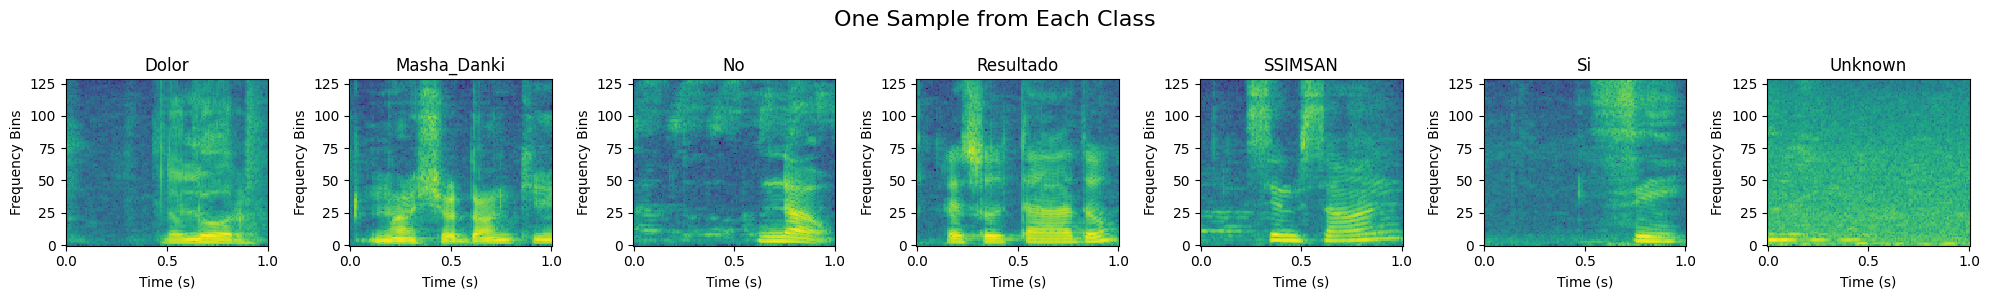

In [ ]:
def inspect_minibatched_sample_shape(loaded_subset: DataLoader) -> None:
    """
    Inspect the shape of one sample from the loaded subset.

    Args:
        loaded_subset (DataLoader): The DataLoader subset.
    """
    one_sample, one_label = next(iter(loaded_subset))
    print(f"Shape of one mini-batched sample: {one_sample.shape}")
    print(f"Shape of one mini-batched label: {one_label.shape}")


# Inspect the shape of one sample from a training set minibatch
inspect_minibatched_sample_shape(train_loader)


def fetch_audio_and_spectrogram_tensor(file_path: str) -> tuple:
    """
    Fetch the audio signal and its spectrogram tensor from a .npz file.

    Args:
        file_path (str): The path to the .npz file.

    Returns:
        tuple: A tuple containing the spectrogram tensor and the reconstructed waveform.
    """
    spec_data = npz_loader(file_path)
    spec_tensor = torch.from_numpy(spec_data).float()
    spec_complex = torch.complex(spec_tensor, torch.zeros_like(spec_tensor))
    spec_complex = spec_complex.transpose(0, 1)
    freq_bins, _ = spec_complex.shape

    n_fft = (freq_bins - 1) * 2
    hop_length = 128
    win_length = n_fft

    window = torch.hann_window(win_length, periodic=False)

    reconstructed_waveform = torch.istft(
        spec_complex,
        n_fft=n_fft,
        hop_length=hop_length,
        win_length=win_length,
        window=window,
        center=True,
        normalized=False,
        onesided=True,
        length=None,
    )

    # Pad or truncate with last value if it is not equal to 16000
    if reconstructed_waveform.shape[0] < 16000:
        reconstructed_waveform = F.pad(
            reconstructed_waveform, (0, 16000 - reconstructed_waveform.shape[0])
        )
    elif reconstructed_waveform.shape[0] > 16000:
        reconstructed_waveform = reconstructed_waveform[:16000]

    return spec_tensor, reconstructed_waveform


def hear_and_visualize_one_of_each_class(dataset_path: str, class_names: list) -> None:
    """
    Hear and visualize one sample from each class from the raw (untransformed) dataset.

    Args:
        dataset_path (str): The path to the dataset.
        class_names (list): The list of class names.
    """

    spectrograms = []

    # Load one npz file from each class folder
    for class_name in class_names:
        label_folder = class_name
        label_dir = os.path.join(dataset_path, label_folder)
        random_file = random.choice(os.listdir(label_dir))
        file_path = os.path.join(label_dir, random_file)

        # Reconstruct the waveform from the spectrogram
        spectrogram, reconstructed_waveform = fetch_audio_and_spectrogram_tensor(
            file_path
        )
        spectrograms.append(spectrogram)

        print(f"Class: {class_name}, File: {random_file}")
        display.display(display.Audio(reconstructed_waveform, rate=16000))

    # Now we visualize the spectrograms, in one row and n-columns == len(class_names)
    fig, axes = plt.subplots(1, len(class_names), figsize=(20, 3))
    fig.suptitle("One Sample from Each Class", fontsize=16)
    for i, (ax, spec, class_name) in enumerate(zip(axes, spectrograms, class_names)):
        # Compute log-scaled spectrogram for better visualization, avoiding log(0)
        log_spec = np.log(spec.numpy().T + np.finfo(np.float32).eps)
        height = log_spec.shape[0]
        width = log_spec.shape[1]
        # Time axis: 0 to 1 second, width points
        X = np.linspace(0, 1, num=width)
        Y = range(height)
        ax.pcolormesh(X, Y, log_spec)
        ax.set_title(class_name)
        ax.set_xlabel("Time (s)")
        ax.set_ylabel("Frequency Bins")
        # ax.set_aspect('equal', adjustable='box')  # Set 1:1 aspect ratio
        ax.grid(False)
    plt.tight_layout()
    plt.subplots_adjust(top=0.75)  # Adjust top to make room for the suptitle
    plt.show()
    plt.close()


hear_and_visualize_one_of_each_class(dataset_path=DATASET_PATH, class_names=class_names)

# Model and Training

# Model Evaluation